Perry Fox 2023-12-08  
https://platform.stratascratch.com/data-projects/sales-data-analysis
# Project - Sales Data Analysis
  
## Data Description
`datasets/` contains 50 CSV files, one per week, of timestamped sales data, two columns in each:  
- `sales_time` - Timestamp on which the sale was made
- `purchaser_gender` - The gender of person who purchased (m or f)

## Objective
Using the data files:

- [Plot daily sales for all 50 weeks](#plot)
- [It looks like there has been a sudden change in daily sales. What date did it occur?](#change)
- [Is the change in daily sales at the date you selected statistically significant? What is the p-value?](#stats)
- [Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers? Use plots to support this answer.](#plot)
- [Assume a given day is divided into four parts. What is the percentage of sales in each daypart over all 50 weeks?](#day)

---

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

## Bring in the sales data

In [2]:
# see what one of the files looks like:
pd.read_csv('datasets/sales_week_starting_2012-10-01.csv').head()
# parse_dates=True, index_col='sale_time'

,sale_time,purchaser_gender
0,2012-10-01 01:42:22,female
1,2012-10-01 02:24:53,female
2,2012-10-01 02:25:40,female
3,2012-10-01 02:30:42,female
4,2012-10-01 02:51:32,male


ok, we can set up a datetime index below when we read in the CSVs from the sale_time column.  

In [3]:
# list out the files
all_files = [file for file in os.listdir('datasets') if file.endswith('.csv')]

# initialize an empty dataframe for these to populate
sales_data = pd.DataFrame()

# loop thru the csv files and concat
for file in all_files:
    file_path = os.path.join('datasets', file) # useful to use OS library here so code works on a different OS
    df = pd.read_csv(file_path, parse_dates=True, index_col='sale_time')
    sales_data = pd.concat([sales_data, df])

Sanity check:

In [119]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204329 entries, 2012-10-01 01:42:22 to 2013-09-15 23:48:47
Data columns (total 1 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   purchaser_gender  204329 non-null  object
dtypes: object(1)
memory usage: 3.1+ MB


Looks good! We also see there are no null values to deal with.

---

## a) Plot Daily Sales for All 50 Weeks

In [78]:
sales_data.head()

,purchaser_gender
sale_time,
2012-10-01 01:42:22,female
2012-10-01 02:24:53,female
2012-10-01 02:25:40,female
2012-10-01 02:30:42,female
2012-10-01 02:51:32,male


In [90]:
# resample to daily granularity, get daily sales, and counts by gender (for use below)
sales_breakdown = sales_data.resample('D').agg(
    ['count', lambda x: x.value_counts().get('female'), lambda x: x.value_counts().get('male')])
# tidy it up a little
sales_breakdown = sales_breakdown.purchaser_gender.rename(
    columns = {'count': 'daily_sales', '<lambda_0>': 'female_sales', '<lambda_1>': 'male_sales'})

In [91]:
sales_breakdown.head()

,daily_sales,female_sales,male_sales
sale_time,,,
2012-10-01,514,413,101
2012-10-02,482,379,103
2012-10-03,499,386,113
2012-10-04,546,432,114
2012-10-05,476,368,108


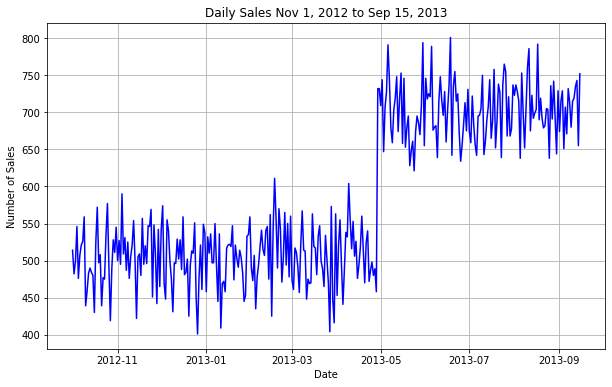

In [92]:
# make a line chart
plt.figure(figsize=(10,6))
plt.plot(sales_breakdown.index, sales_breakdown.daily_sales, color='blue')
plt.title('Daily Sales Nov 1, 2012 to Sep 15, 2013')
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.grid()

## b) It looks like there has been a sudden change in daily sales. What date did it occur?

In [95]:
# grab the daily changes for daily_sales
daily_sales_diff = sales_breakdown.daily_sales.diff()
daily_sales_diff.nlargest(1)

sale_time
2013-04-29    274.0
Name: daily_sales, dtype: float64

We see that the sudden change took place on April 29th, with a jump from the prior day of 274 sales.

## c) Is the change in daily sales at the date you selected statistically significant? What's the p-value?

In the visualization above, the jump we see on April 29 seems to divide two periods of very different mean sales numbers. To establish the statistical significance of this change, we'll perform a t-test on the means of these two groups. The difference is visually striking, and I imagine there will be no problem setting the critical value to 99%. 

$ H_0 $ = There is no difference between the average sales number prior to and after the observed jump.  
$ H_1 $ = There is a difference. 

In [98]:
date_sudden_change = daily_sales_diff.nlargest(1).index[0]
date_sudden_change

Timestamp('2013-04-29 00:00:00')

In [129]:
# establish the two sales periods
#     lower sales counts series
sales_before_jump = \
    sales_breakdown.loc[sales_breakdown.index < date_sudden_change]
#     higher sales counts series
sales_after_jump = \
    sales_breakdown.loc[sales_breakdown.index >= date_sudden_change]

# t-test
t_stat, p_val = stats.ttest_ind(sales_before_jump.daily_sales, sales_after_jump.daily_sales) 
print(f'We have a p_val of {p_val}')

We have a p_val of 2.27287631770394e-149


Okay, that number is minuscule. We can interpret this by saying, **yes** the difference of the mean sales between the two periods is statistically significant. The probability of random chance accounting for this difference is close to 0.  
It might also be appropriate to look at the change itself, and its statistical significance to the mean of the other sales changes we see in the dataset. This will be done with a One Sample T-test, and we'll be comparing the highest observed change we see of 274 to the mean of all the changes in this time period.

In [126]:
# clipping the first element from daily_sales_diff because test can't take nulls
stats.ttest_1samp(daily_sales_diff[1:], daily_sales_diff.nlargest(1)[0])

Ttest_1sampResult(statistic=-88.84860321865489, pvalue=3.0520000042500664e-241)

And again, a super small p-value. The change the price jump represents is in no way similar to the average change observed. 

## d) Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers? Use plots to support this answer.

In [131]:
sales_before_jump.head()

,daily_sales,female_sales,male_sales
sale_time,,,
2012-10-01,514,413,101
2012-10-02,482,379,103
2012-10-03,499,386,113
2012-10-04,546,432,114
2012-10-05,476,368,108


[Text(0, 0, 'female'), Text(1, 0, 'male')]

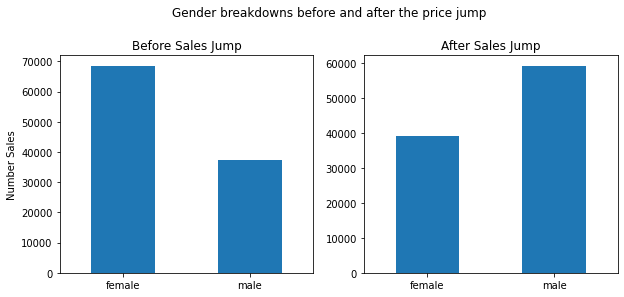

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
# Plot the data
sales_before_jump[['female_sales','male_sales']].sum().plot(kind='bar', ax=axes[0])
sales_after_jump[['female_sales','male_sales']].sum().plot(kind='bar', ax=axes[1])

# Make it more presentable
# Ensure consistent x-axis range for both subplots
fig.suptitle('Gender breakdowns before and after the price jump', y=1.05)
axes[0].set_title('Before Sales Jump')
axes[0].set_xticklabels(['female', 'male'], rotation=0)
axes[0].set_ylabel('Number Sales')

axes[1].set_title('After Sales Jump')
axes[1].set_xticklabels(['female', 'male'], rotation=0)

In [149]:
# for quick index reference in the cell below
sales_before_jump.sum()

daily_sales     105924
female_sales     68589
male_sales       37335
dtype: int64

In [150]:
before_pct_female = round(100*\
    (sales_before_jump.sum()[1] / sales_before_jump.sum()[0]), 2)
before_pct_male = 100 - before_pct_female
print(f'Gender breakdown before jump was {before_pct_female}% female and \
{before_pct_male}% male.')

Gender breakdown before jump was 64.75% female and 35.25% male.


In [152]:
after_pct_female = round(100*\
    (sales_after_jump.sum()[1] / sales_after_jump.sum()[0]), 2)
after_pct_male = 100 - after_pct_female
print(f'Gender breakdown after jump was {after_pct_female}% female and \
{after_pct_male}% male.')

Gender breakdown after jump was 39.79% female and 60.21% male.


It's interesting to see that the gender ratios effectively swapped post-jump, but it's hard to say this is what caused the jump. It might be revealing to see how sudden or gradual this gender ratio swap was: 

In [156]:
sales_breakdown.head()

,daily_sales,female_sales,male_sales
sale_time,,,
2012-10-01,514,413,101
2012-10-02,482,379,103
2012-10-03,499,386,113
2012-10-04,546,432,114
2012-10-05,476,368,108


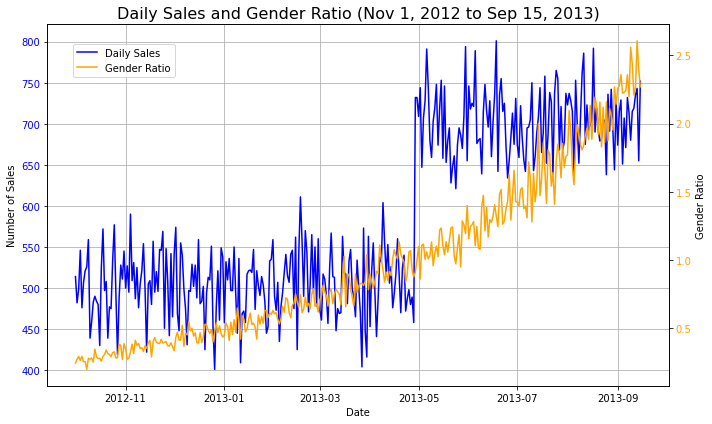

In [169]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# plot the daily sales on the left y-axis
ax1.plot(sales_breakdown.index, sales_breakdown.daily_sales, color='blue', label='Daily Sales')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Sales')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid()

# create a second y-axis on the right side
ax2 = ax1.twinx()

# plot the gender ratio, f/m
ax2.plot(sales_breakdown.male_sales / sales_breakdown.female_sales, color='orange', label='Gender Ratio')
# ax2.plot(sales_breakdown.index, sales_breakdown.male_sales / sales_breakdown.female_sales, color='orange', label='Gender Ratio')
ax2.set_ylabel('Gender Ratio')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Daily Sales and Gender Ratio (Nov 1, 2012 to Sep 15, 2013)', fontsize=16)
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
fig.set_facecolor('white')

Okay, that answers our question. Nothing special appear to happen with the gender ratio around the time of the sales jump. It's a gradual increase. The reason for the jump must be something else. More data needed.

## e) Assume a given day is divided into four parts. What is the percentage of sales in each daypart over all 50 weeks?

In [218]:
# sales_data is our original dataframe
sales_data.head()

,purchaser_gender
sale_time,
2012-10-01 01:42:22,female
2012-10-01 02:24:53,female
2012-10-01 02:25:40,female
2012-10-01 02:30:42,female
2012-10-01 02:51:32,male


In [219]:
# resample to equal daily periods
sales_daypart_df = \
    sales_data.resample('6H').count().rename(columns={'purchaser_gender':'sales_count'})

sales_daypart_df.head()

,sales_count
sale_time,
2012-10-01 00:00:00,44
2012-10-01 06:00:00,155
2012-10-01 12:00:00,202
2012-10-01 18:00:00,113
2012-10-02 00:00:00,46


In [220]:
# get total sales, our denominator for the percentage calculation
total_sales = sales_data.shape[0]

# group by the hour groups we set up, the numerators
sales_daypart_df = sales_daypart_df.groupby(sales_daypart_df.index.time).sum()
sales_daypart_df

,sales_count
00:00:00,18306
06:00:00,62870
12:00:00,80533
18:00:00,42620


In [222]:
sales_daypart_df['percentage'] = (sales_daypart_df.sales_count / total_sales*100).map("{:.2f}%".format)
sales_daypart_df['day_part'] = ['night','morning', 'afternoon','evening']
sales_daypart_df.rename_axis('Time')

,sales_count,percentage,day_part
Time,,,
00:00:00,18306,8.96%,night
06:00:00,62870,30.77%,morning
12:00:00,80533,39.41%,afternoon
18:00:00,42620,20.86%,evening
